## Imports

In [ ]:
import pandas as pd
import numpy as np
import random

from scipy.misc import imshow
from scipy.misc import imread
import os
import matplotlib.pyplot as plt
%matplotlib inline

# For fixing the randomness and thereby enabling my team members to reproduce the experiments
np.random.seed(7)

import warnings
warnings.filterwarnings("ignore")

## Label file loading and data shuffling

In [ ]:
filename_csv = pd.read_csv('/floyd/input/histology_data/dat.csv', sep=',')
filename_csv.head()

In [ ]:
from sklearn.utils import shuffle

filename_csv = shuffle(filename_csv)
filename_csv.head()

## Conversion to numeric quantities (in half precision)

In [ ]:
from scipy.misc import imresize
import numpy as np

# Uniforming the precision to half sp as to speed up the training (NVIDIA inspired)
temp = []
for img_name in filename_csv.filename:
    img_path = os.path.join('/floyd/input/histology_data', 'pool', img_name)
    img = imread(img_path)
    img = imresize(img, (256,192))
    img = img.astype('float32') 
    temp.append(img)

X = np.stack(temp)

## Encode the labels into one-hot encoded vectors

In [ ]:
import keras
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

y = lb.fit_transform(filename_csv['label'])
y = keras.utils.np_utils.to_categorical(y)

## Import ImageGenerator and ResNet (custom)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# From PyImageSearch's Adrian Rosebrock
from resnet import ResNet

## Learning Rate Schedule (Exponential Decay)

In [ ]:
NUM_EPOCHS = 128
INIT_LR = 1e-1
BS = 32
def poly_decay(epoch):
    maxEpochs = NUM_EPOCHS
    baseLR = INIT_LR
    power = 1.0
 
    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
 
    # return the new learning rate
    return alpha

## Model building and compilation

In [ ]:
# Initialize our ResNet model
model = ResNet.build(192, 256, 3, 8, (3, 4, 6),
                    (16, 32, 64, 128), reg=0.0005)

# Define the optimizer (other variants are also needed to be tried)
from keras.optimizers import SGD
opt = SGD(lr=INIT_LR, momentum=0.9)

# Compile the model to optimize the categorical_crossentropy as the loss function
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

## Construct Data Augmentation pipeline

In [ ]:
# Prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

train_datagen.fit(X)
train_generator = train_datagen.flow(X,
                                     y, 
                                     batch_size=32)

## Define the callbakcs - LearningRateSchedule, EarlyStopping and TensorBoard

In [ ]:
from keras.callbacks import EarlyStopping, TensorBoard, LearningRateScheduler

callbacks = [EarlyStopping(monitor='loss', patience=20), \
             TensorBoard(log_dir='./logs'), \
             LearningRateScheduler(poly_decay)]

## Begin model training

In [ ]:
train_steps_per_epoch = X.shape[0] // BS

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              epochs=NUM_EPOCHS,
                              verbose=1, callbacks=callbacks)

In [21]:
# Save the model weights
model.save_weights("weights/model.h5")

## Performance visualization

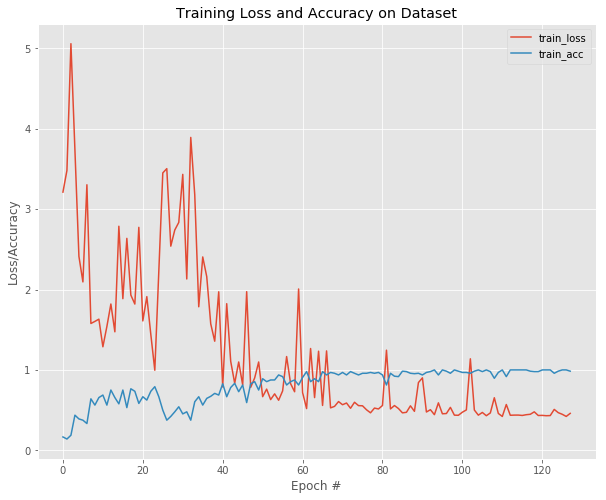

In [23]:
plt.style.use("ggplot")
plt.figure(figsize=(10,8))
plt.plot(np.arange(0, 128), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 128), history.history["acc"], label="train_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

## Model predicition and performance evaluation in terms of numbers

In [28]:
predictions = model.predict_on_batch(X)

In [34]:
accuracy_score(y, predictions)

0.125

## It is underfitting to my wonder but the loss/train tradeoff graph as specified above tells a different story. I will debug this thoroughly tomorrow to see what am 